In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
from utils import get_Hz_ppm_conversion, zero_padding
from scipy.signal import ShortTimeFFT, windows
from pre_processing import PreProcessing
from data_augmentation import TransientMaker

In [2]:
with h5py.File('../sample_data.h5') as hf:
    print(hf.keys())
    ppm = hf['ppm'][()]
    t = hf['t'][()]
    fids = hf['ground_truth_fids'][()]
    #print(hf['data_2048'].keys())

<KeysViewHDF5 ['ground_truth_fids', 'ppm', 't']>


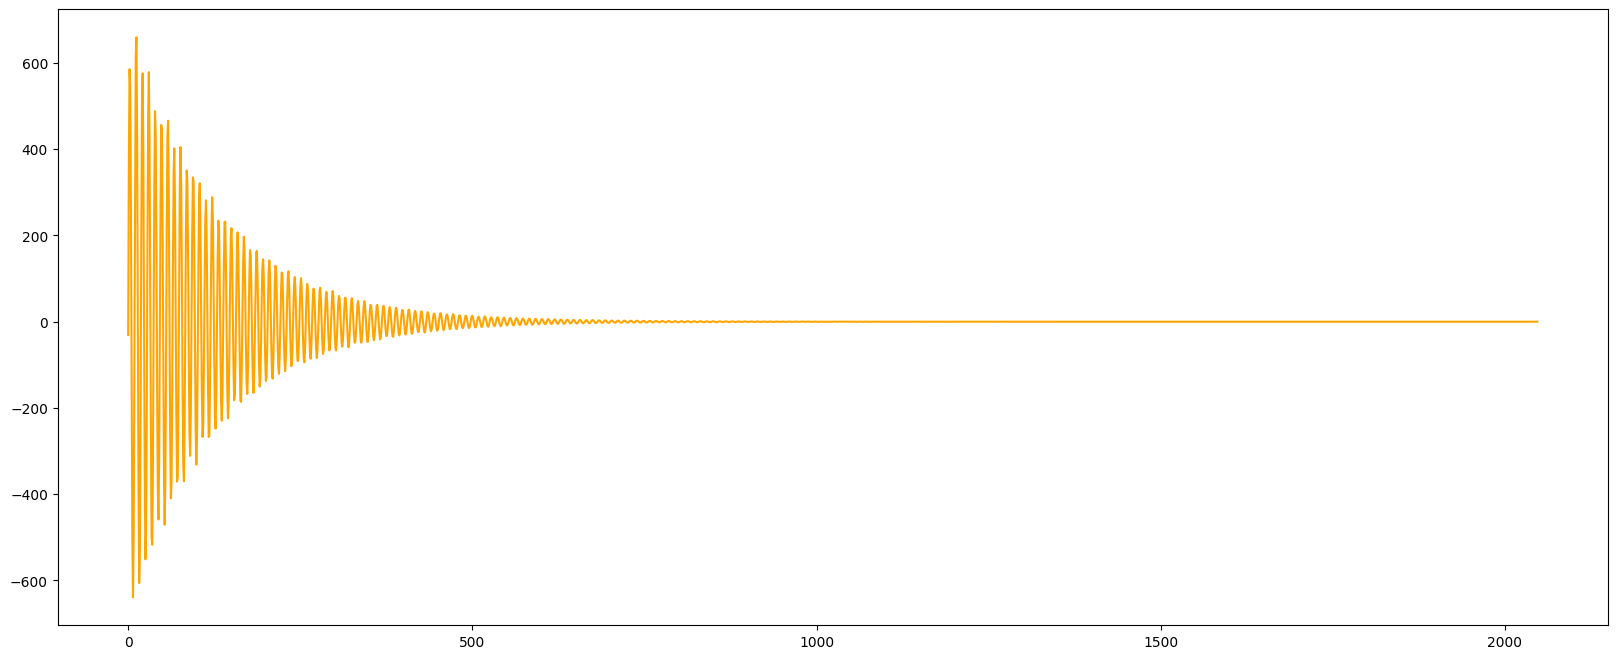

In [3]:
fig = plt.figure(figsize=(20,8))
#plt.plot(np.real(fids[0,:,0]))
plt.plot(np.imag(fids[0,:,0]),color='orange')

In [4]:
spectra_gt_fid = np.fft.fftshift(np.fft.fft(fids, n=fids.shape[1], axis=1), axes=1)
spectrum = spectra_gt_fid[:,:, 1] - spectra_gt_fid[:,:, 0]

In [5]:
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(fids.shape[1], d=(t[0, 1] - t[0, 0]))))

In [7]:
print(np.abs(freq - (-250)).argmin())
print(np.abs(freq - (750)).argmin())

1279
255


In [8]:
print(ppm[0,1279])
print(freq[1279])
print(ppm[0,255])
print(freq[255])

1.046584472446
-250.0
8.87553750655675
750.0


(-500.0, 800.0)

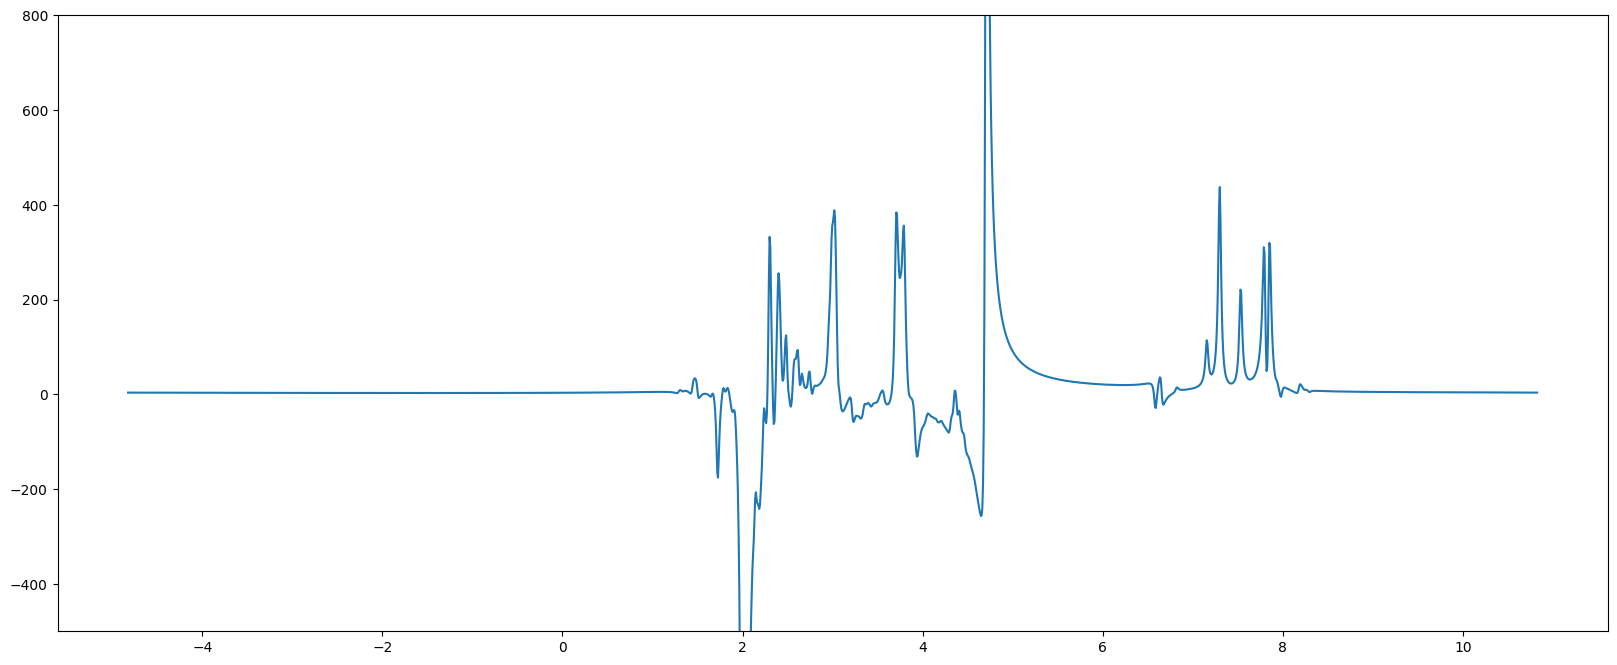

In [22]:
fig = plt.figure(figsize=(20,8))
plt.plot(ppm[0,:],np.flip(np.real(spectrum[0,:])))
plt.ylim(-500,800)
#plt.xlim(ppm[0,255],ppm[0,1279])


In [20]:
from utils import get_normalized_spgram
spgram = get_normalized_spgram(fid=fids[0,:,1]-fids[0,:,0], fs=1/(t[0, 1] - t[0, 0]), larmorfreq=127.9, linear_shift=3, window_size=256, hop_size=30, window=windows.hann(256,sym=True))


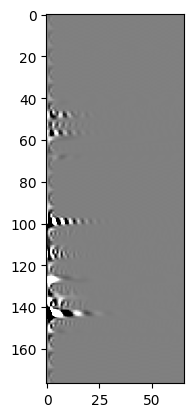

In [21]:
plt.imshow(np.real(spgram),cmap='gray',vmin=-0.04,vmax=0.04)

In [2]:
with h5py.File('../dataset_tracks2and3_training_data.h5') as hf:
    print(hf.keys())
    ppm = hf['ppm'][()]
    t = hf['t'][()]
    target = hf['target_spectra'][()]
    fids = hf['transient_fids'][()]
    #print(hf['data_2048'].keys())

<KeysViewHDF5 ['ppm', 't', 'target_spectra', 'transient_fids']>


In [3]:
print(ppm.shape)
print(t.shape)
print(target.shape)
print(fids.shape)

(19, 2048)
(19, 2048)
(19, 2048)
(19, 2048, 2, 160)


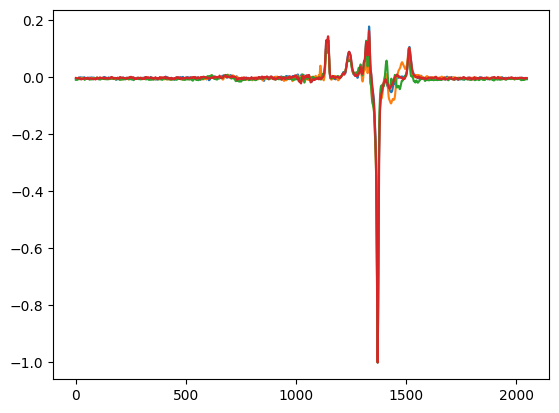

In [4]:
plt.plot(target[0,:]/np.max(np.abs(target[0,:])))
plt.plot(target[1,:]/np.max(np.abs(target[1,:])))
plt.plot(target[3,:]/np.max(np.abs(target[3,:])))
plt.plot(target[2,:]/np.max(np.abs(target[2,:])))

In [5]:
print(np.real(fids[0,2000:,0,0]).max())
print(np.real(fids[1,:,0,0]).min())


123027.42916185792
-0.0041403272189199924


In [6]:
int(np.floor(np.log10(abs(99))))

1

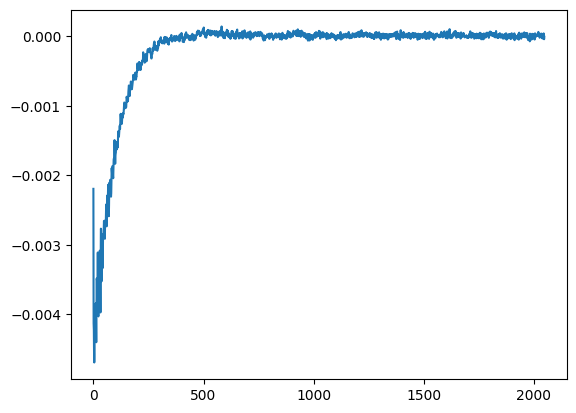

In [7]:
plt.plot(np.real(fids[1,:,1,0]))
#plt.plot(np.real(fids[1,:,0,0]))

In [8]:
a_inv, b = get_Hz_ppm_conversion(gt_fids=fids, dwelltime=t[0,1]-t[0,0], ppm=ppm)

In [9]:
class DatasetSpgramRealData(Dataset):
    def __init__(
        self,
        path_data,
        augment_with_noise,
        augment_with_idx_repetition,
        start=None,
        end=None,
        fs=None,
        larmorfreq=None,
        linear_shift=None,
        hop_size=None,
        window_size=None,
        window=None,
        qntty_to_augment_by_idx=None,
        **kwargs_augment_by_noise
    ):

        self.path_data = path_data
        self.augment_with_noise = augment_with_noise
        self.augment_with_idx_repetition = augment_with_idx_repetition
        self.get_item_first_time = True
        self.random_augment = kwargs_augment_by_noise

        with h5py.File(self.path_data) as hf:
            ppm = hf['ppm'][()][:1]
            t = np.empty((1,ppm.shape[-1]))
            hf["t"].read_direct(t,source_sel=np.s_[0:1])
            fids = hf['transient_fids'][()][:1]
            self.fids_transient_qntty = fids.shape[-1]
            total_qntty = len(hf['transient_fids'])

        if start is not None and end is not None:
            self.start_pos = start
            self.end_pos = end
        elif start is not None and end is None:
            self.start_pos = start
            self.end_pos = total_qntty
        elif start is None and end is not None:
            self.start_pos = 0
            self.end_pos = end
        else:
            self.start_pos = 0
            self.end_pos = total_qntty

        if self.augment_with_idx_repetition is True and qntty_to_augment_by_idx is not None:
            self.qntty_to_augment_by_idx = qntty_to_augment_by_idx
        elif self.augment_with_idx_repetition is True and qntty_to_augment_by_idx is None:
            self.qntty_to_augment_by_idx = 200
        else:
            self.qntty_to_augment_by_idx = None

        if fs == None:
            dwelltime = t[0, 1] - t[0, 0]
            self.fs = 1 / dwelltime
        else:
            self.fs = fs

        if larmorfreq == None or linear_shift == None:
            a_inv, b = get_Hz_ppm_conversion(
                gt_fids=fids, dwelltime=1 / self.fs, ppm=ppm
            )
        if larmorfreq == None and linear_shift == None:
            self.larmorfreq = a_inv
            self.linear_shift = b
        elif larmorfreq == None and linear_shift != None:
            self.larmorfreq = a_inv
            self.linear_shift = linear_shift
        elif larmorfreq != None and linear_shift == None:
            self.larmorfreq = larmorfreq
            self.linear_shift = b
        else:
            self.larmorfreq = larmorfreq
            self.linear_shift = linear_shift

        if hop_size is not None and window_size is not None and window is not None:
            if window.shape[0] == window_size:
                self.SFT = ShortTimeFFT(
                    win=window,
                    hop=hop_size,
                    fs=self.fs,
                    mfft=window_size,
                    scale_to="magnitude",
                    fft_mode="centered",
                )
                self.hop_size = hop_size
                self.window_size = window_size
                self.window = window
            else:
                self.SFT = None
                self.hop_size = None
                self.window_size = None
                self.window = None
        else:
            self.SFT = None
            self.hop_size = None
            self.window_size = None
            self.window = None
        
        if self.augment_with_idx_repetition is True:
            self.idx_data = np.empty(self.qntty_to_augment_by_idx * (self.end_pos - self.start_pos), dtype="int")
            idx_counter = 0
            for i in range(self.start_pos, self.end_pos):
                for j in range(self.qntty_to_augment_by_idx):
                    self.idx_data[self.qntty_to_augment_by_idx * idx_counter + j] = i
                idx_counter=idx_counter+1
        else:
            self.idx_data = np.arange(self.start_pos, self.end_pos)

    def __len__(self) -> int:
        return self.idx_data.shape[0]
    
    def _get_interval_method_augment(self, key):
        if key in self.random_augment.keys():
            max = self.random_augment[key]["noise_level_base"]["max"] + 1
            min = self.random_augment[key]["noise_level_base"]["min"]

            noise_level_base = np.random.randint(min, max)

            max = self.random_augment[key]["noise_level_scan_var"]["max"] + 1
            min = self.random_augment[key]["noise_level_scan_var"]["min"]

            noise_level_scan_var = np.random.randint(min, max)

            return noise_level_base, noise_level_scan_var
        else:
            return None,None
        
    def _get_random_transients(self,high):
        idx_transient_samples = np.random.randint(low=0,high=high,size=40)
        return idx_transient_samples
    
    def _modulate_value(self,decimal_value, vector):
        max_value = np.max(np.abs(vector))
        order_of_magnitude = int(np.floor(np.log10(max_value))) if max_value != 0 else 0
        if order_of_magnitude == 0 or order_of_magnitude==1:
            modulated_value = decimal_value
        else:
            modulated_value = decimal_value * 10**(order_of_magnitude-1)
        return modulated_value

    def __getitem__(
        self, idx: int
    ) -> (torch.Tensor, torch.Tensor, torch.Tensor, float, str):

        filename = self.path_data
        idx_in_file = self.idx_data[idx]
        noise_amplitude_base, noise_amplitude_var = self._get_interval_method_augment("amplitude")
        noise_frequency_base, noise_frequency_var = self._get_interval_method_augment("frequency")
        noise_phase_base, noise_phase_var = self._get_interval_method_augment("phase")

        with h5py.File(self.path_data) as hf:
            ppm = hf["ppm"][()][idx_in_file]
            t = np.empty((1,ppm.shape[-1]))
            hf['t'].read_direct(t,source_sel=np.s_[idx_in_file : idx_in_file + 1])
            
            aug_fids = np.empty((1,ppm.shape[-1],2,40),dtype='complex128')
            spectrum = np.empty((ppm.shape[-1]),dtype='float64')
            hf['target_spectra'].read_direct(spectrum,source_sel=np.s_[idx_in_file])
            if self.fids_transient_qntty > 40:
                fid_aux = np.empty((1,ppm.shape[-1],2,self.fids_transient_qntty),dtype='complex128')
                hf['transient_fids'].read_direct(fid_aux,source_sel=np.s_[idx_in_file : idx_in_file + 1])
            else:
                hf['transient_fids'].read_direct(aug_fids,source_sel=np.s_[idx_in_file : idx_in_file + 1])

        if self.fids_transient_qntty > 40:
            if self.augment_with_idx_repetition is True:
                idx_transient_samples = self._get_random_transients(high=self.fids_transient_qntty)
                for i in range(len(idx_transient_samples)):
                    aug_fids[0,:,:,i] = fid_aux[0,:,:,idx_transient_samples[i]]
            else:
                aug_fids = fid_aux[:,:,:,:40]
        
        if self.augment_with_noise is True:
            transientmkr = TransientMaker(fids=aug_fids, t=t, create_transients=False)
            if noise_amplitude_base is not None and noise_amplitude_var is not None:
                noise_amplitude_base_mod = self._modulate_value(noise_amplitude_base, np.real(aug_fids[0,int(ppm.shape[0]/4):,:,:]))
                noise_amplitude_var_mod = self._modulate_value(noise_amplitude_var, np.real(aug_fids[0,int(ppm.shape[0]/4):,:,:]))
                transientmkr.add_random_amplitude_noise(noise_level_base=noise_amplitude_base_mod, 
                                                        noise_level_scan_var=noise_amplitude_var_mod)
            if noise_frequency_base is not None and noise_frequency_var is not None:
                transientmkr.add_random_frequency_noise(noise_level_base=noise_frequency_base, 
                                                        noise_level_scan_var=noise_frequency_var)
            if noise_phase_base is not None and noise_phase_var is not None:
                transientmkr.add_random_phase_noise(noise_level_base=noise_phase_base, 
                                                        noise_level_scan_var=noise_phase_var)
            aug_fids = transientmkr.fids
        
        
        spectrogram1 = PreProcessing.spgram_channel(
            fid_off=aug_fids[0, :, 0, 0:14],
            fid_on=aug_fids[0, :, 1, 0:14],
            fs=self.fs,
            larmorfreq=self.larmorfreq,
            linear_shift=self.linear_shift,
            hop_size=self.hop_size,
            window_size=self.window_size,
            window=self.window,
            SFT=self.SFT,
        )

        spectrogram2 = PreProcessing.spgram_channel(
            fid_off=aug_fids[0, :, 0, 14:27],
            fid_on=aug_fids[0, :, 1, 14:27],
            fs=self.fs,
            larmorfreq=self.larmorfreq,
            linear_shift=self.linear_shift,
            hop_size=self.hop_size,
            window_size=self.window_size,
            window=self.window,
            SFT=self.SFT,
        )

        spectrogram3 = PreProcessing.spgram_channel(
            fid_off=aug_fids[0, :, 0, 27:40],
            fid_on=aug_fids[0, :, 1, 27:40],
            fs=self.fs,
            larmorfreq=self.larmorfreq,
            linear_shift=self.linear_shift,
            hop_size=self.hop_size,
            window_size=self.window_size,
            window=self.window,
            SFT=self.SFT,
        )

        if self.get_item_first_time == True:
            print("Generating Spectrograms of size: ", spectrogram1.shape)

        spectrogram1 = zero_padding(spectrogram1)
        spectrogram1 = spectrogram1[np.newaxis, ...]
        if self.get_item_first_time == True:
            print("Zero padded to shape: ", spectrogram1.shape)
            self.get_item_first_time = False
        spectrogram1 = torch.from_numpy(np.real(spectrogram1))

        spectrogram2 = zero_padding(spectrogram2)
        spectrogram2 = spectrogram2[np.newaxis, ...]
        spectrogram2 = torch.from_numpy(np.real(spectrogram2))

        spectrogram3 = zero_padding(spectrogram3)
        spectrogram3 = spectrogram3[np.newaxis, ...]
        spectrogram3 = torch.from_numpy(np.real(spectrogram3))
        three_channels_spectrogram = torch.concat(
            [spectrogram1, spectrogram2, spectrogram3]
        )

        constant_factor = np.max(np.abs(spectrum))
        spectra_norm = spectrum / constant_factor
        target_spectrum = torch.from_numpy(np.real(spectra_norm))
        ppm = torch.from_numpy(ppm)

        return (
            three_channels_spectrogram.type(torch.FloatTensor),
            target_spectrum.type(torch.FloatTensor),
            ppm,
            constant_factor,
            filename,
            aug_fids
        )

In [10]:
dataset =  DatasetSpgramRealData(path_data='../dataset_tracks2and3_training_data.h5',
        augment_with_noise=True,
        augment_with_idx_repetition=True,
        start=0,
        end=7,
        hop_size=10,
        window_size=256,
        window=windows.hann(256,sym=True),
        qntty_to_augment_by_idx=200,
        **{'amplitude':{'noise_level_base':{'max':10,'min':2},
                                    'noise_level_scan_var':{'max':2,'min':0}},
                                'frequency':{'noise_level_base':{'max':6,'min':2},
                                    'noise_level_scan_var':{'max':2,'min':0}},
                                'phase':{'noise_level_base':{'max':6,'min':2},
                                     'noise_level_scan_var':{'max':2,'min':0}}})



In [11]:
dataloader = DataLoader(dataset=dataset,batch_size=10,shuffle=True)
counter=0
for batch in dataloader:
    input_, target_, ppm_, _, _, fids_= batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]
    counter=counter+1
    break
#plt.imshow(input_[4,1,:,:].detach().numpy(),cmap='gray',vmin=-0.04,vmax=0.04)

Generating Spectrograms of size:  (204, 199)
Zero padded to shape:  (1, 224, 224)


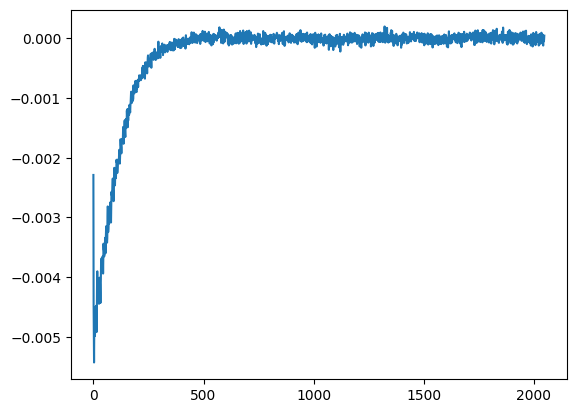

In [12]:
plt.plot(np.real(fids_[2,0,:,0,0]))

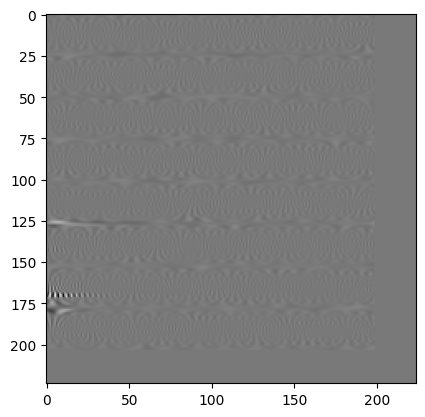

In [13]:
plt.imshow(input_[6,0,:,:],cmap='gray')

(4.0, 1.0)

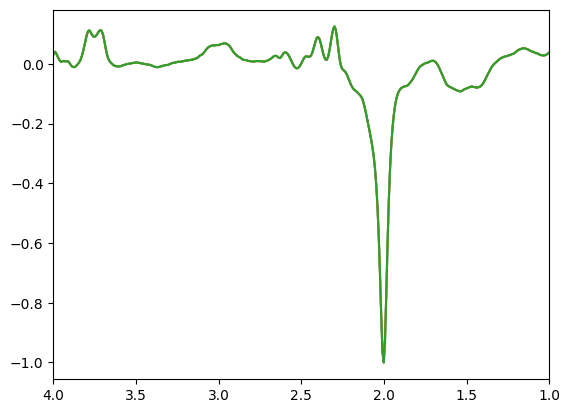

In [63]:
plt.plot(ppm_[0,:],target_[0,:])
plt.plot(ppm_[5,:],target_[5,:])
plt.plot(ppm_[9,:],target_[9,:])
plt.xlim(4,1)